# Prediction 23-24 season winner using 22-23 season data

___

### 22-23 season data handling

In [1]:
# import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# load 22-23 season data
data_22 = pd.read_csv("/data/22-23.csv")

# define the function for convert results to integers
def result(HG, AG):
    if HG > AG:
        return -1
    elif HG == AG:
        return 0
    elif HG < AG:
        return 1
    
# calculate new result columns in 22-23 season data
data_22["Result"] = data_22.apply(lambda row: result(row.FTHG, row.FTAG), axis = 1)

# split 22-23 season data into home and away then combine average score and conceded score
home_data_22 = data_22.groupby("HomeTeam").sum()
away_data_22 = data_22.groupby('AwayTeam').sum()
home_data_22['HAS'] = home_data_22['FTHG'] / 19 # Home Average Scores
home_data_22['HAC'] = home_data_22['FTAG'] / 19 # Home Average Conceded
away_data_22['AAS'] = away_data_22['FTAG'] / 19 # Away average Scored
away_data_22['AAC'] = away_data_22['FTHG'] / 19 # Away Average Conceded

# make Dataframe that index is 20 teams
team_data_22 = pd.DataFrame()
team_data_22["Team"] = home_data_22.index

# add "HAS", "HAC", "AAS", "AAC" into "team_data_22" Dataframe and set index as teams
team_data_22 = team_data_22.merge(home_data_22['HAS'], left_on='Team', right_index=True)
team_data_22 = team_data_22.merge(home_data_22['HAC'], left_on='Team', right_index=True)
team_data_22 = team_data_22.merge(away_data_22['AAS'], left_on='Team', right_index=True)
team_data_22 = team_data_22.merge(away_data_22['AAC'], left_on='Team', right_index=True)
team_data_22.set_index(keys = "Team", inplace = True)

# scaling "team_data_22" Dataframe
scaler = MinMaxScaler()
team_data_22 = pd.DataFrame(scaler.fit_transform(team_data_22), 
                            columns=team_data_22.columns, 
                            index=team_data_22.index)

# use "data_22" Dataframe for feature selection and calculate "Attack Strength"
data_22 = data_22.merge(team_data_22['HAS'], left_on='HomeTeam', right_index=True, how='left')
data_22 = data_22.merge(team_data_22['HAC'], left_on='HomeTeam', right_index=True, how='left')
data_22 = data_22.merge(team_data_22['AAS'], left_on='AwayTeam', right_index=True, how='left')
data_22 = data_22.merge(team_data_22['AAC'], left_on='AwayTeam', right_index=True, how='left')
data_22['HAtS'] = (data_22['HAS'] * data_22['AAC']); # Home Attack Strength
data_22['AAtS'] = (data_22['HAC'] * data_22['AAS']); # Away Attack Strength

# load 5 years relative record and handling that data
vsRecord_22 = pd.read_csv("/data/17-22.cut.csv",
                         sep = "\t")

# define relative strength and calculate
def power(HW, D, HL):
    if HW == D == HL == 0:
        return -1
    return (HW + D) / (HW + D + HL)
vsRecord_22["Power"] = vsRecord_22.apply(lambda x: power(x.HW, x.D, x.HL), axis = 1)

# using Imputer for convert missing value into Median
imp = SimpleImputer(strategy = "median", missing_values = -1)
vsRecord_22["Power"] = imp.fit_transform(vsRecord_22.iloc[:, 5:6])

# combine relative record and handling data
data_22 = pd.concat([data_22, vsRecord_22], axis = 1)

/tmp/ipykernel_1705026/1817589519.py:29: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_data_22 = data_22.groupby("HomeTeam").sum()
/tmp/ipykernel_1705026/1817589519.py:30: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away_data_22 = data_22.groupby('AwayTeam').sum()


___

### Feature selection

/opt/anaconda/envs/kh_env/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


test_data_accuracy : 0.8157894736842105


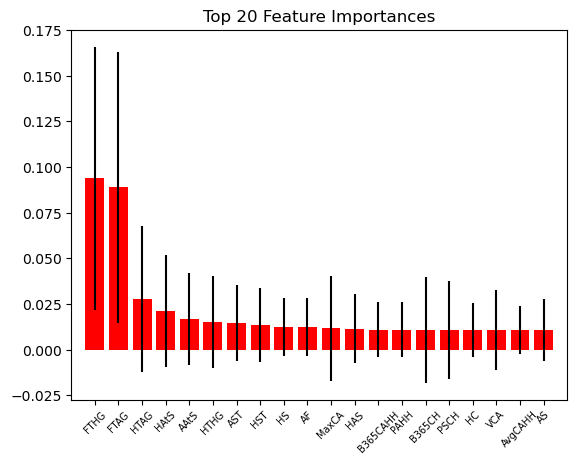

In [2]:
# drop some columns
rm_col_list = ['HomeTeam','AwayTeam', "Div", "Date", "Time", "FTR", "HTR", "Referee", "H", "A"]
drop_data_22 = data_22.drop(rm_col_list, axis = 1)

# set X, Y
col_list = drop_data_22.columns
X = [x for x in col_list if x != 'Result']
Y = [x for x in col_list if x == 'Result']
X_data = drop_data_22[X]
Y_data = drop_data_22[Y]

# model configure
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, Y_train)
print("test_data_accuracy :", model.score(X_test, Y_test))

# calculate feature's importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

# using bar plot for feature importance's visualization
top_indices = indices[:20]  # choose top 20 features
plt.figure()
plt.title("Top 20 Feature Importances")
plt.bar(range(len(top_indices)), importances[top_indices],
        color="r", yerr=std[top_indices], align="center")
plt.xticks(range(len(top_indices)), X_data.columns[top_indices], rotation=45, fontsize=7)
plt.xlim([-1, len(top_indices)]) 
plt.show()

In [3]:
# I need to erase data that may come out after the game such as total goal
# Beacase those datas can't be used for prediction
# Also I can see how 'Power' powerfull

In [4]:
# check feature one by one to see our feature's power
print("Feature ranking")
for f in range(X_data.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X_data.columns[indices][f], importances[indices[f]]))

Feature ranking
1. feature FTHG (0.094)
2. feature FTAG (0.089)
3. feature HTAG (0.028)
4. feature HAtS (0.021)
5. feature AAtS (0.017)
6. feature HTHG (0.015)
7. feature AST (0.015)
8. feature HST (0.013)
9. feature HS (0.012)
10. feature AF (0.012)
11. feature MaxCA (0.012)
12. feature HAS (0.012)
13. feature B365CAHH (0.011)
14. feature PAHH (0.011)
15. feature B365CH (0.011)
16. feature PSCH (0.011)
17. feature HC (0.011)
18. feature VCA (0.011)
19. feature AvgCAHH (0.011)
20. feature AS (0.011)
21. feature AAC (0.010)
22. feature Power (0.010)
23. feature PAHA (0.010)
24. feature WHH (0.010)
25. feature AvgCAHA (0.010)
26. feature BWH (0.009)
27. feature HAC (0.009)
28. feature B365AHH (0.009)
29. feature MaxCAHH (0.009)
30. feature PCAHH (0.009)
31. feature MaxAHA (0.009)
32. feature PCAHA (0.009)
33. feature HY (0.009)
34. feature MaxCAHA (0.009)
35. feature PSCA (0.009)
36. feature MaxAHH (0.009)
37. feature WHCH (0.009)
38. feature B365CA (0.008)
39. feature AvgAHH (0.008)
40.

___

### Model configure

In [5]:
# set X, Y
col_list = ["HAtS", "AAtS", "HAS", "HAC", "AAS", "AAC", "Power", "HW", "D", "HL"]
X_data = data_22[col_list]
Y_data = data_22['Result']

# model configuration
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)
model1 = RandomForestClassifier()
model1.fit(X_train, Y_train)
print("test_data_accuracy :", model1.score(X_test, Y_test))

# train
predicted = model1.predict(X_test)

test_data_accuracy : 0.5


In [6]:
# Accuracy check
acc_score = accuracy_score(Y_test, predicted)
print("Accuracy score: " + str(acc_score))
scores = cross_val_score(model1, X_train, Y_train, cv=10)
print("Cross val scores")
print(scores)

Accuracy score: 0.5
Cross val scores
[0.61290323 0.58064516 0.61290323 0.4516129  0.36666667 0.6
 0.53333333 0.56666667 0.56666667 0.43333333]


In [7]:
# prediction
predicted = model1.predict(X_data)
predictedDF_22 = pd.DataFrame(predicted, columns=['Predicted'])

# make predicted season Dataframe
prediction_season_22 = pd.DataFrame(index = team_data_22.index)
prediction_season_22['Actual Points'] = 0 
prediction_season_22['Predicted Points'] = 0

# define function that convert result column into real point
def make_actual_table(x, ht, at, which):
    if x == -1:
        prediction_season_22.loc[ht, which] += 3
    elif x == 0:
        prediction_season_22.loc[ht, which] += 1
        prediction_season_22.loc[at, which] += 1
    elif x == 1:
        prediction_season_22.loc[at, which] += 3

# merge "data_22" and "predictedDF_22"
data_22 = data_22.merge(predictedDF_22, left_index = True, right_index = True)

# make actual table
data_22.apply(lambda x: make_actual_table(x.Result, x.HomeTeam, x.AwayTeam, 'Actual Points'), axis=1)
data_22.apply(lambda x: make_actual_table(x.Predicted, x.HomeTeam, x.AwayTeam, 'Predicted Points'), axis=1)

# sorting
actual_index = prediction_season_22.sort_values(by='Actual Points', ascending=0).index
predicted_index = prediction_season_22.sort_values(by='Predicted Points', ascending=0).index
prediction_season_22.sort_values(by='Actual Points', ascending=0)

,Actual Points,Predicted Points
Team,,
Man City,89,96
Arsenal,84,77
Man United,75,79
Newcastle,71,77
Liverpool,67,70
Brighton,62,62
Aston Villa,61,60
Tottenham,60,62
Brentford,59,60


In [8]:
# Accuracy on just ranking table
def acc(act, prd):
    count = 0
    for i, val in enumerate(act):
        if str(act[i]) == str(prd[i]):
            count += 1
    print("Accuracy of Predicted Table to Accurate Table " + str((count/20)*100) + "%")
acc(actual_index,predicted_index)

# 22/23 Season predicted table
prediction_season_22.sort_values(by='Predicted Points', ascending =0)

Accuracy of Predicted Table to Accurate Table 30.0%


,Actual Points,Predicted Points
Team,,
Man City,89,96
Man United,75,79
Arsenal,84,77
Newcastle,71,77
Liverpool,67,70
Tottenham,60,62
Brighton,62,62
Brentford,59,60
Aston Villa,61,60


___

### 23-24 season data handling

In [9]:
# load half of 23_24 season data and calculate Result
data_23_half = pd.read_csv("/data/23-24.cut.csv")
data_23_half['Result'] = data_23_half.apply(lambda row: result(row.FTHG, row.FTAG), axis = 1) 

# split 23-24 season data into home and away then combine average score and conceded score
home_data_23 = data_23_half.groupby("HomeTeam").sum()
away_data_23 = data_23_half.groupby('AwayTeam').sum()
home_data_23['HAS'] = home_data_23['FTHG'] / 9.5 # Home Average Scores
home_data_23['HAC'] = home_data_23['FTAG'] / 9.5 # Home Average Conceded
away_data_23['AAS'] = away_data_23['FTAG'] / 9.5 # Away average Scored
away_data_23['AAC'] = away_data_23['FTHG'] / 9.5 # Away Average Conceded

# make Dataframe that index is 20 teams
team_data_23 = pd.DataFrame()
team_data_23["Team"] = home_data_23.index

# add "HAS", "HAC", "AAS", "AAC" into "team_data_23" Dataframe and set index as teams
team_data_23 = team_data_23.merge(home_data_23['HAS'], left_on='Team', right_index=True)
team_data_23 = team_data_23.merge(home_data_23['HAC'], left_on='Team', right_index=True)
team_data_23 = team_data_23.merge(away_data_23['AAS'], left_on='Team', right_index=True)
team_data_23 = team_data_23.merge(away_data_23['AAC'], left_on='Team', right_index=True)
team_data_23.set_index(keys = "Team", inplace = True)

# scaling "team_data_23" Dataframe
team_data_23 = pd.DataFrame(scaler.fit_transform(team_data_23), 
                            columns=team_data_23.columns, 
                            index=team_data_23.index)

# subset promoted teams
team_list = ["Burnley", "Luton", "Sheffield United"]
subset_team_data_23 = team_data_23.loc[team_list]

# combine subset promoted teams and previous team data
team_data = pd.concat([team_data_22, subset_team_data_23], axis = 0)
team_data

# load 23-24 full season table
data_23 = pd.read_csv("/data/epl-2023.csv", 
                            usecols=['Home Team', 'Away Team'])
data_23.columns = ['HomeTeam', 'AwayTeam']
team_data = team_data.rename(index={
    'Sheffield United':'Sheffield Utd',
    'Man United': 'Man Utd',
    'Tottenham':'Spurs',
    "Nott'm Forest":"Nottingham Forest"})

# add "HAS", "HAC", "AAS", "AAC" into "data_23"
data_23 = data_23.merge(team_data['HAS'], left_on='HomeTeam', right_index=True, how='left')
data_23 = data_23.merge(team_data['HAC'], left_on='HomeTeam', right_index=True, how='left') 
data_23 = data_23.merge(team_data['AAS'], left_on='AwayTeam', right_index=True, how='left') 
data_23 = data_23.merge(team_data['AAC'], left_on='AwayTeam', right_index=True, how='left') 
data_23['HAtS'] = (data_23['HAS'] * data_23['AAC']); # Home Attack Strength
data_23['AAtS'] = (data_23['HAC'] * data_23['AAS']); # Away Attack Strength 

# load 5 years relative record and handling that data
vsRecord_23 = pd.read_csv("/data/18-23.cut.csv",
                         sep = "\t")

# using Imputer for convert missing value into Median
vsRecord_23["Power"] = vsRecord_23.apply(lambda x: power(x.HW, x.D, x.HL), axis = 1)
vsRecord_23["Power"] = imp.fit_transform(vsRecord_23.iloc[:, 5:6])

# combine relative record and handling data
data_23 = pd.concat([data_23, vsRecord_23], axis = 1)

# if want check column's value then print mismatched values
# mismatched_H = data_23[data_23["HomeTeam"] != data_23["H"]]
# mismatched_A = data_23[data_23["AwayTeam"] != data_23["A"]]
# print(mismatched_H, mismatched_A)

/tmp/ipykernel_1705026/2145730538.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  home_data_23 = data_23_half.groupby("HomeTeam").sum()
/tmp/ipykernel_1705026/2145730538.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  away_data_23 = data_23_half.groupby('AwayTeam').sum()


___

### Prediction 23-24 season result

In [10]:
# set X and predict
col_list = ["HAtS", "AAtS", "HAS", "HAC", "AAS", "AAC", "Power", "HW", "D", "HL"]
X_data = data_23[col_list]
predicted_23 = model1.predict(X_data)
predictedDF_23 = pd.DataFrame(predicted_23, columns=['Predicted'])

# add "Predicted" column into "data_23" Dataframe
data_23 = data_23.merge(predictedDF_23, left_index = True, right_index = True)

# make 23-24 season Dataframe
team_data_23 = team_data_23.rename(index={
    'Sheffield United':'Sheffield Utd',
    'Man United': 'Man Utd',
    'Tottenham':'Spurs',
    "Nott'm Forest":"Nottingham Forest"})
prediction_season_23 = pd.DataFrame(index = team_data_23.index)
prediction_season_23['Predicted Points'] = 0

# define function that convert result column into real point
def make_actual_table(x, ht, at, which):
    if x == -1:
        prediction_season_23.loc[ht, which] += 3
    elif x == 0:
        prediction_season_23.loc[ht, which] += 1
        prediction_season_23.loc[at, which] += 1
    elif x == 1:
        prediction_season_23.loc[at, which] += 3
data_23.apply(lambda x: make_actual_table(x.Predicted, x.HomeTeam, x.AwayTeam, 'Predicted Points'), axis=1)
prediction_season_23.sort_values('Predicted Points', ascending=0)

,Predicted Points
Team,
Man City,95
Arsenal,86
Newcastle,86
Man Utd,80
Liverpool,79
Spurs,72
Brighton,62
Aston Villa,59
Fulham,54


___

### Check prediction failure

In [11]:
# compare predicted result and real result than evaluate the model
# so I wonder if the matches that failed to predict were Intense or Not
# I judged that it was an overwhelming game if the difference in the final score was more than two

In [12]:
# load 23_24 season data and calculate Result
real_data = pd.read_csv("/data/23-24.csv")
real_data["Result"] = real_data.apply(lambda row: result(row.FTHG, row.FTAG), axis = 1)

# subset columns for check prediction failure
col_list = ["FTHG", "FTAG", "Result"]
real_data = real_data[col_list]

# merge predicted data and real match result data
data_23 = data_23.merge(real_data, left_index = True, right_index = True)

# make new dataframe for check
incorrect_predictions = data_23[data_23['Predicted'] != data_23['Result']]
correct_predictions = data_23[data_23['Predicted'] == data_23['Result']]

# split intense and not intense matches
def intense(HG, AG):
    if abs(HG - AG) >= 2:
        return 1
    else:
        return 0
    
# calculate new result columns in 22-23 season data
incorrect_predictions["intense"] = incorrect_predictions.apply(lambda row: intense(row.FTHG, row.FTAG), axis = 1)
correct_predictions["intense"] = correct_predictions.apply(lambda row: intense(row.FTHG, row.FTAG), axis = 1)

# calculate precentage and count
incorrect_pct = incorrect_predictions['intense'].value_counts(normalize=True)*100
correct_pct = correct_predictions['intense'].value_counts(normalize=True)*100
incorrect_counts = incorrect_predictions["intense"].value_counts()
correct_counts = correct_predictions["intense"].value_counts()

# make dataframe for visualization
incorrect_pct = pd.Series([incorrect_pct[0], incorrect_pct[1]], index=[0, 1], name="incorrect")
correct_pct = pd.Series([correct_pct[0], correct_pct[1]], index=[0, 1], name="correct")
bar_data = {'0': [incorrect_pct[0], correct_pct[0]], '1': [incorrect_pct[1], correct_pct[1]]}
bar_df = pd.DataFrame(bar_data, index=['Incorrect', 'Correct'])
bar_df

/tmp/ipykernel_1705026/2809849274.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_predictions["intense"] = incorrect_predictions.apply(lambda row: intense(row.FTHG, row.FTAG), axis = 1)
/tmp/ipykernel_1705026/2809849274.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_predictions["intense"] = correct_predictions.apply(lambda row: intense(row.FTHG, row.FTAG), axis = 1)


,0,1
Incorrect,59.471366,40.528634
Correct,47.712418,52.287582


/tmp/ipykernel_1705026/3224360579.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  index = pd.np.arange(len(bar_df))


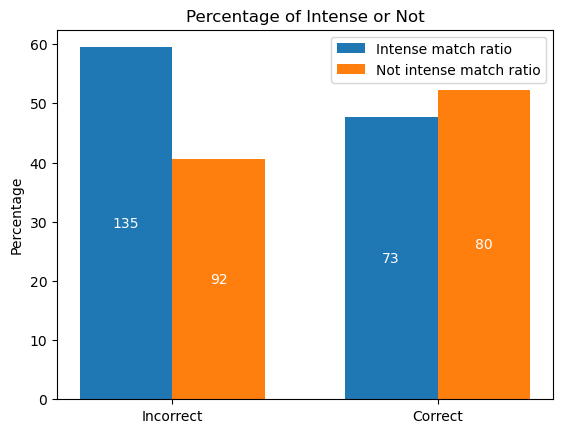

In [13]:
# draw bar plot
bar_width = 0.35
index = pd.np.arange(len(bar_df))

fig, ax = plt.subplots()
bars1 = ax.bar(index, bar_df['0'], bar_width, label='Intense match ratio')
bars2 = ax.bar(index + bar_width, bar_df['1'], bar_width, label='Not intense match ratio')

ax.text(index[0], bar_df['0'][0] / 2, str(incorrect_counts[0]), ha='center', va='center', color='white')
ax.text(index[0] + bar_width, bar_df['1'][0] / 2, str(incorrect_counts[1]), ha='center', va='center', color='white')
ax.text(index[1], bar_df['0'][1] / 2, str(correct_counts[0]), ha='center', va='center', color='white')
ax.text(index[1] + bar_width, bar_df['1'][1] / 2, str(correct_counts[1]), ha='center', va='center', color='white')

ax.set_ylabel('Percentage')
ax.set_title('Percentage of Intense or Not')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(bar_df.index)
ax.legend()

plt.show()

In [14]:
# whether it's a intense or not, it is difficult to predict
# Furthermore, it is very ambiguous to determine if it is a intense match

In [15]:
# What I know is that the stronger intensity, the harder to predict